# Pytorch Custom Datasets


### 0. Importing PyTorch and setting up device-agnostic code

In [4]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.3.1+cu121'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get Data
- Our dataset is a subset of the Food101 dataset.
- Food101 starts with 101 different categories of food and 1000 images per class ( 750 training, 250 each testing)
- Our dataset starts with 3 classes of food and only 10% of the images (~75% training, 25 testing each)
- Why do this?
- When starting with ML project, it's important to try things on small scale and then increase the scale when necessary.
- The whole point is to speed up how fast you can experiment.

In [6]:
import requests
import zipfile
from pathlib import Path

# Setup path to the data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist , download it and perpare it
if image_path.is_dir():
    print(f"{image_path} directory already exists ..... skipping download")
else:
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb")as f:
    #### Always copy the raw file from the github
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading.....")
    f.write(request.content)

# unzip the zip file downloaded
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset.......")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ..... skipping download
Downloading.....
Unziping the dataset.......


### 2. Becoming one with the data ( data preparation and data exploration )

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [7]:
# Setup training and testing paths **
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing and images

Lets write some code to:
1. Get all of the image paths
2. Pick a random image path using python's `random.choice()`
3. Get the image class name using `Pathlib.Path.parent.stem`
4. Since we are working with images, open the image using PIL library
5. We will show th image and print the data

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image Height: 408
Image Width: 512


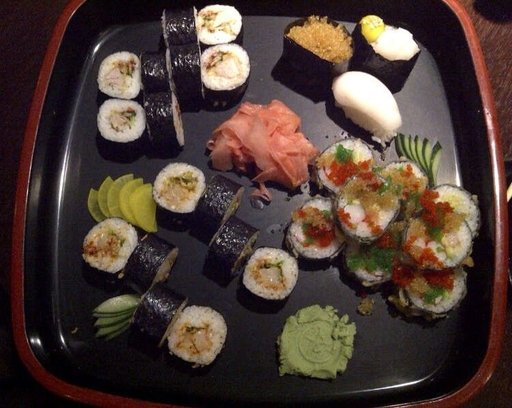

In [7]:
import random
from PIL import Image

# set Seed
random.seed(42)

# 1.  get all the image paths
image_path_lists = list(image_path.glob("*/*/*.jpg"))

# 2. Random image path and plot it
random_image_path = random.choice(image_path_lists)
#print(random_image_path)

# 3. Get the image class from the path name ( the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image 
img = Image.open(random_image_path)

# 5. print Metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img


In [28]:
# try to visulaize the image with mmatplotlib library
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_as_array.shape} -> [Height, Width, Colour Channel]")
plt.axis(False);

NameError: name 'img' is not defined

### 3. Transforming Data
Before we can use our data with pytorch:
1. Turn your target data into tensors ( in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset`  sunsequently turned into `torch.utils.data.DataLoader`
3. 

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.transforms
Transforms help you get your images ready to be used with a model/perform data augmentation Link: https://pytorch.org/vision/stable/transforms.html

In [16]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the images into a torch.Tensor
    transforms.ToTensor()
])

In [38]:
def plot_transformed_images(image_path, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/Transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(42)
    random_image_path = random.sample(image_path, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:    
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f) # type: ignore
            ax[0].set_title(f"Original\nSize: {f.size}") # type: ignore
            ax[0].axis(False) # type: ignore

            # TRansform and plot target image
            transformed_image = transform(f).permute(1,2,0) # changing the order from (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path=image_path_lists,
                        transform=data_transform,
                        n=3,
                        seed=42
                        )

NameError: name 'image_path_lists' is not defined

#### 4.1 Option 1. Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder` : https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder


In [17]:
# Use the ImageFolder to create datasets(s)
# Pre-build datasets function developed ny Pytorch to load the data in certain structure format
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # type: ignore
                                  transform=data_transform, # A transform for the data (Custom ones)
                                  target_transform=None, # A transform for the target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform
                                 )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict()
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the length of our datasets
len(train_data), len(test_data)

(225, 75)

In [16]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [17]:
# index on the train data Dataset to get a single image and label
img, label = train_data[0]
print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {class_names[label]}")
print(f"Label Dataype: {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> [Color_channels,Height,Width]
Image PErmuted shape: torch.Size([64, 64, 3]) -> [Height, Width, color_channels]


Text(0.5, 1.0, 'pizza')

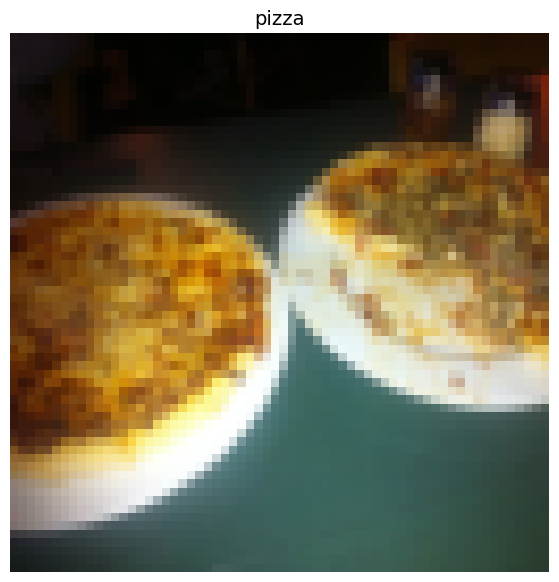

In [18]:
# Rearrage the order of dimensions
img_permute = img.permute(1,2,0)

# print out different shapes
print(f"Original Shape: {img.shape} -> [Color_channels,Height,Width]")
print(f"Image PErmuted shape: {img_permute.shape} -> [Height, Width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

#### 4.1 Turn datasets into `Dataloader`
A `Dataloader` is going to help turn our datasets into iterables and we can customize the `batch_size` so our model can see batch size at one time.

In [19]:
import os
os.cpu_count()

20

In [20]:
# Turn traina and test into dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,#os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,#os.cpu_count(),
                             shuffle=True)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
img, label = next(iter(train_dataloader))

# Batrch size will be one, you can change the batch size if you like
print(f"Image Shape: {img.shape} -> [batch_size, colour_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, colour_channels, height, width]
Label Shape: torch.Size([1])


### 5 Option 2: Loading Image data with Custom `Dataset` instead using Pytorch nuild in functionality.
1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to pytorch pre-built `dataset` functions

Cons:
* Even though you could create `Datasets` out of almost anything, it doesnt mean it wil work.....
* Using a `Custom Dataset` often results in us writing more code, which could be prone to more errors or peformance issues.

All customs datasets in pytorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
 

In [1]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [2]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

NameError: name 'train_data' is not defined

#### 5.1 Creating a helper function to get class names
We want a function to:
1. Get the class names using `os.scandir` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if te class names aren't found (if this happens, there might be something wrong with directort structure)
3. Turn the class names into a dict and  alist and return them.

In [8]:
# Setup Path for target directory
from matplotlib import image


target_directory = train_dir
print(f"Target Dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [9]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [10]:
# Turn the Above Steps into a executable function
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
    """Finds the Class folder names in a target directory"""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

    # 2. Raise an error if class names not to be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.... Please Check!!!")
    
    # 3. Create a dictionary of index labels ( comapre prefer numbers rather than strings as labels )
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

#### 5.2 Create a custom `Dataset` to replicate `ImageFolder` functionality
* To create our Own dataset, we ewant to:
1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target dicrectory ( the directory we would like to get data from ) as well as a transform if we would like to transform our data
3. Create several attributes:
* paths - paths of out images
* transform - the transform we would like to perform
* classes - a list to get the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to `load_images()`, this function will open images
5. Overwrite `__len()__` method to return the length of our dataset
Overwrite the `__getitem()__` method to returhn a given sample when passed an index

In [11]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                targ_dir: str,
               transform=None):
        # 3. Create class attributes
        # Get all the images paths here
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes adn class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_images(self, index: int) -> Image.Image:
        """Opens an image via path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len()__
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)
    
    # 6. Overwrite __getitem()__ method to return a sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, and the data label (X,y)"""
        img = self.load_images(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # Return data and lable index
        else:
            return img, class_idx # type: ignore # return untransformed image and label index

In [12]:
# test our custom dataset function
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [13]:
# Test our custom ImageFolderCustom
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms
)

test_data_custom = ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms
)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1e93e97db40>,
 <__main__.ImageFolderCustom at 0x1e93e97c8b0>)

In [20]:
# The original one
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [21]:
len(train_data), len(train_data_custom)

(225, 225)

In [22]:
len(test_data), len(test_data_custom)


(75, 75)

In [23]:
# Check for equality between original imageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


#### 5.3 Create a function to display random images

1. Taken in `Dataset` and number of other paramerters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, lets cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a lsit of random sample indexes from the target dataset.
5. Setup a matlplotlib plot.
6. Loop through the random sample images and plot them with matpotlib.
7. Make sure the dimensions of our images line up with matplotlib.

In [29]:
# 1. Create a function to take in a dataset
import random
def display_random_images(dataset: torch.utils.data.Dataset, # type: ignore
                          classes: List[str]=None, # type: ignore
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None): # type: ignore
    # 2. Adjust if n is very high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For Display, Purpose, n shouldn't be larger than 10, setting to 10 and removing the display")
    
    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get the random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup Matplotlib plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # Changing [C,H,W] -> [H,W,C]

        # Plot the adjusted Image
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

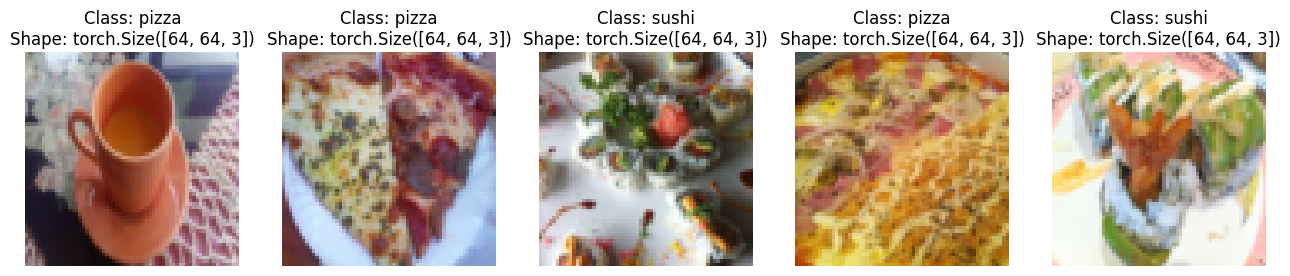

In [30]:
# Display random images fromt the ImageFolder created in ImageFolder
display_random_images(dataset=train_data,
                      n=5,
                      classes = class_names,
                      seed=None)

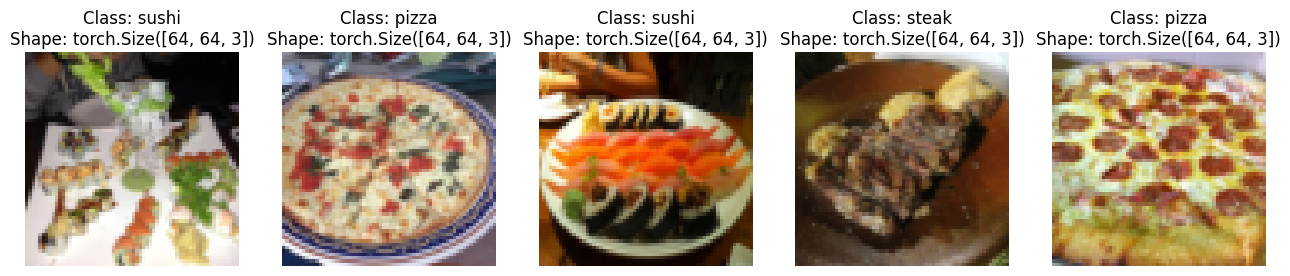

In [31]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      )

#### 5.4 Turn custom Loaded images into DataLoaders

In [32]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUMBER_WORKERS = 0  # os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUMBER_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUMBER_WORKERS,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1e9429ad7e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e9429ae380>)

In [33]:
# Get Image adn label from custom Dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6 Other forms of transforms ( Data Augmentation )
* Data augmentation is the process of artificially addign diversity to your trainign data.
* In this case of image data, this may mean applying various image transformation to the trainig images.
* Lets take a look at one aprticular type of data augmentation used to train PyTorch vision models to state of the art levels....
* this practise enables model to generalize more on the unseeen data
* blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
* Augmentations : https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [41]:
# lets look at Trivial Augment -> https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])



In [35]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [42]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

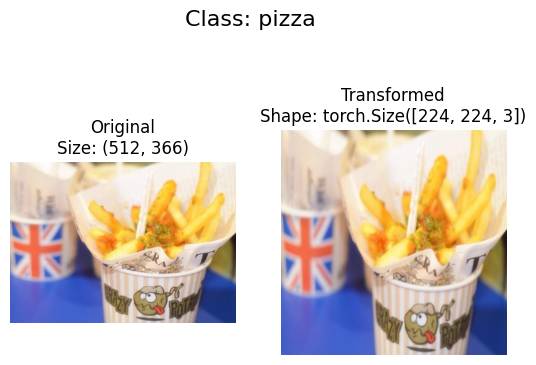

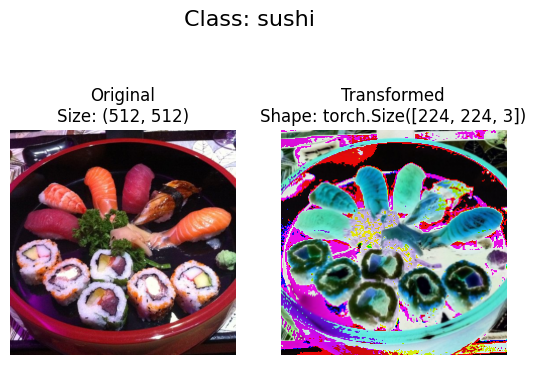

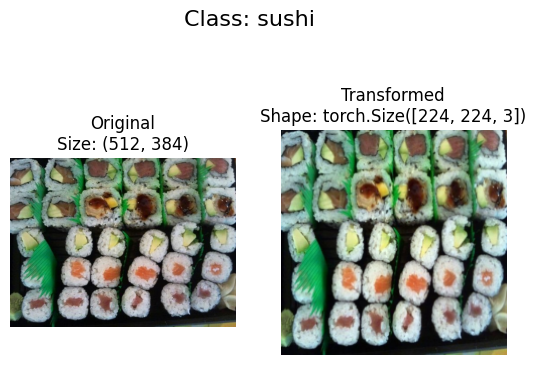

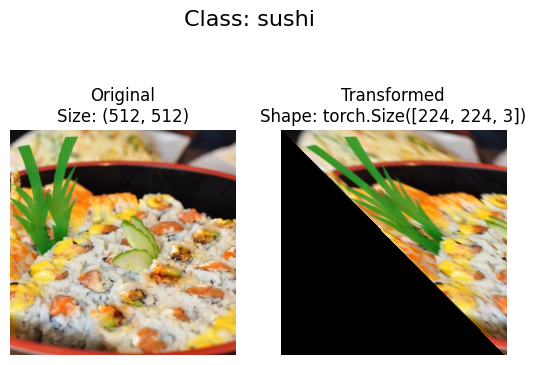

In [44]:
# Plot random transformed images
plot_transformed_images(image_path=image_path_list,
                        transform=train_transform,
                        n=4,
                        seed=42)

### 7 Model 0: TinyVGG without the data augmentation

#### 7.1 Creating Transform and loading data for Model 0

In [45]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [193]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2, Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and the number of works
BATCH_SIZE = 32
NUM_WORKERS = 1#os.cpu_count()

# CCreate DataLaoders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 7.2 Create TinyVGG model class

reading article : https://horace.io/brrr_intro.html

In [13]:
class TinyVGG(nn.Module):
    """Model Architecture copying TinyVGG from cnn Explainer"""
    def __init__(self, input_shape: int,
                hidden_units: int,
                output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default value of stride is same as kernel size

        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )


    def forward(self, x):
        # x = self.conv_block_1(x)
        # #print(x.shape)
        # x = self.conv_block_2(x)
        # #print(x.shape)
        # x = self.classifier_layer(x)
        #return x
        return self.classifier_layer(self.conv_block_2(self.conv_block_1(x))) # benefits of using this type of syntax

In [165]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

In [166]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image data ( to test te model)

In [195]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [196]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0196, -0.0014,  0.0108],
        [ 0.0209,  0.0001,  0.0089],
        [ 0.0198, -0.0038,  0.0090],
        [ 0.0191, -0.0013,  0.0104],
        [ 0.0228, -0.0037,  0.0093],
        [ 0.0245, -0.0048,  0.0085],
        [ 0.0209,  0.0001,  0.0084],
        [ 0.0224, -0.0014,  0.0080],
        [ 0.0179,  0.0004,  0.0087],
        [ 0.0186, -0.0042,  0.0095],
        [ 0.0182, -0.0003,  0.0076],
        [ 0.0183, -0.0008,  0.0152],
        [ 0.0183,  0.0002,  0.0060],
        [ 0.0213, -0.0039,  0.0110],
        [ 0.0232, -0.0035,  0.0095],
        [ 0.0198, -0.0023,  0.0090],
        [ 0.0202, -0.0023,  0.0073],
        [ 0.0211, -0.0018,  0.0083],
        [ 0.0203,  0.0033,  0.0065],
        [ 0.0219, -0.0002,  0.0091],
        [ 0.0186, -0.0020,  0.0091],
        [ 0.0205, -0.0025,  0.0085],
        [ 0.0208,  0.0018,  0.0080],
        [ 0.0194,  0.0016,  0.0103],
        [ 0.0216, -0.0044,  0.0095],
        [ 0.0195, -0.0022,  0.0100],
        [ 0.0197, -0.0009,  0.0093],
 

##### To get the output shapes of the layers created int he model class

In [150]:
# Defined functions to calcluate the output shapes from every layer
import math

def num2tuple(num):
    return num if isinstance(num, tuple) else (num, num)

def conv2d_output_shape(h_w, hiddle_shape: int=10, batch_size: int=32, kernel_size=1, stride=1, pad=0, dilation=1):
    h_w, kernel_size, stride, pad, dilation = num2tuple(h_w), \
        num2tuple(kernel_size), num2tuple(stride), num2tuple(pad), num2tuple(dilation)
    pad = num2tuple(pad[0]), num2tuple(pad[1])
    
    h = math.floor((h_w[0] + sum(pad[0]) - dilation[0]*(kernel_size[0]-1) - 1) / stride[0] + 1)
    w = math.floor((h_w[1] + sum(pad[1]) - dilation[1]*(kernel_size[1]-1) - 1) / stride[1] + 1)
    
    return batch_size,hiddle_shape,h, w

def convtransp2d_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1, out_pad=0):
    h_w, kernel_size, stride, pad, dilation, out_pad = num2tuple(h_w), \
        num2tuple(kernel_size), num2tuple(stride), num2tuple(pad), num2tuple(dilation), num2tuple(out_pad)
    pad = num2tuple(pad[0]), num2tuple(pad[1])
    
    h = (h_w[0] - 1)*stride[0] - sum(pad[0]) + dilation[0]*(kernel_size[0]-1) + out_pad[0] + 1
    w = (h_w[1] - 1)*stride[1] - sum(pad[1]) + dilation[1]*(kernel_size[1]-1) + out_pad[1] + 1
    
    return h, w

def conv2d_get_padding(h_w_in, h_w_out, kernel_size=1, stride=1, dilation=1):
    h_w_in, h_w_out, kernel_size, stride, dilation = num2tuple(h_w_in), num2tuple(h_w_out), \
        num2tuple(kernel_size), num2tuple(stride), num2tuple(dilation)
    
    p_h = ((h_w_out[0] - 1)*stride[0] - h_w_in[0] + dilation[0]*(kernel_size[0]-1) + 1)
    p_w = ((h_w_out[1] - 1)*stride[1] - h_w_in[1] + dilation[1]*(kernel_size[1]-1) + 1)
    
    return (math.floor(p_h/2), math.ceil(p_h/2)), (math.floor(p_w/2), math.ceil(p_w/2))

def convtransp2d_get_padding(h_w_in, h_w_out, kernel_size=1, stride=1, dilation=1, out_pad=0):
    h_w_in, h_w_out, kernel_size, stride, dilation, out_pad = num2tuple(h_w_in), num2tuple(h_w_out), \
        num2tuple(kernel_size), num2tuple(stride), num2tuple(dilation), num2tuple(out_pad)
        
    p_h = -(h_w_out[0] - 1 - out_pad[0] - dialation[0]*(kernel_size[0]-1) - (h_w[0] - 1)*stride[0]) / 2
    p_w = -(h_w_out[1] - 1 - out_pad[1] - dialation[1]*(kernel_size[1]-1) - (h_w[1] - 1)*stride[1]) / 2
    
    return (math.floor(p_h/2), math.ceil(p_h/2)), (math.floor(p_w/2), math.ceil(p_w/2))

#### 7.4 Use `torchinfo` to get an idea of the shapes going through out model

In [170]:
## Another way to get the informatin of our model ####
from torchinfo import summary
#model = TinyVGG(input_shape=3,hidden_units=10,output_shape=10)
summary(model_0,input_size=(BATCH_SIZE,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

#### 7.5 Crete a train dna test step loop functions

* `train_step()`: takes in a mdoel and dataloader and trains the model on the dataloader
* `test_step()`: takes in a model and the dataloader and evaluates the model on the dataloader


In [14]:
# Create train_step funcxtion
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model to train mode
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0, 0

    # loop through dataloader data batches
    for batch, (X,y) in enumerate(dataloader):
        # send data tot eh target device
        X, y = X.to(device), y.to(device)

        # 1. forward Pass
        y_pred = model(X) # output is in logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Soptimizer to zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. Optmizer step
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust mertrics to get the average metrics per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [15]:
# Create a test step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put the model to eval mode
    model.eval()

    # setup test loss and test accuract metrics
    test_loss, test_acc = 0, 0

    # Trurn on inference mode
    with torch.inference_mode():
        # loop througfh thte dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            # convert to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    # Adjust the metrics to get the average of the accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

#### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [16]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader +++
def train_loop(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device
          ):
    # 2. Create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]
               }
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out  whats happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss: .4f} | Train acc: {train_acc: .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. return the filled results at the end of the epochs
    return results

#### 7.7 Train and evaluate our model

In [200]:
device="cuda"
# set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
NUM_EPOCHS = 30

# recreate an instance of tinyVGG
model_0 = TinyVGG(input_shape=3, # Number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# start the timer 
from timeit import default_timer as timer
start_time = timer()

# train the model_0
model_0_results = train_loop(model=model_0, # type: ignore
                             train_dataloader=train_dataloader_simple,
                             test_dataloader=test_dataloader_simple,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS,
                             device=device)

end_time = timer()
print(f"Total trainig timing for {NUM_EPOCHS} : {end_time - start_time: .3f} seconds")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train Loss:  1.1063 | Train acc:  0.3047 | Test loss:  1.0983 | Test acc:  0.3011
Epoch: 1 | Train Loss:  1.0998 | Train acc:  0.3281 | Test loss:  1.0697 | Test acc:  0.5417
Epoch: 2 | Train Loss:  1.0868 | Train acc:  0.4883 | Test loss:  1.0807 | Test acc:  0.4924
Epoch: 3 | Train Loss:  1.0846 | Train acc:  0.4023 | Test loss:  1.0606 | Test acc:  0.5833
Epoch: 4 | Train Loss:  1.0664 | Train acc:  0.4180 | Test loss:  1.0660 | Test acc:  0.5644
Epoch: 5 | Train Loss:  1.0311 | Train acc:  0.4375 | Test loss:  1.0146 | Test acc:  0.5426
Epoch: 6 | Train Loss:  0.9850 | Train acc:  0.4219 | Test loss:  0.9324 | Test acc:  0.5938
Epoch: 7 | Train Loss:  0.9632 | Train acc:  0.5820 | Test loss:  1.0031 | Test acc:  0.4640
Epoch: 8 | Train Loss:  0.9236 | Train acc:  0.5938 | Test loss:  1.0683 | Test acc:  0.3324
Epoch: 9 | Train Loss:  0.9884 | Train acc:  0.4648 | Test loss:  1.0372 | Test acc:  0.3939
Epoch: 10 | Train Loss:  0.8666 | Train acc:  0.5312 | Test loss:  0.9

In [178]:
model_0_results

{'train_loss': [1.1063238680362701,
  1.0997932404279709,
  1.0868596136569977,
  1.0846457928419113,
  1.0663658529520035],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.41796875],
 'test_loss': [1.09832759698232,
  1.0697228113810222,
  1.0807385047276814,
  1.0606043736139934,
  1.0660206079483032],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

#### 7.8 plot the loss curve of model 0
* A **loss curve** is a way to track your models progress over time.

In [179]:
# get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [23]:
from typing import Dict

def plot_loss_curves(results: Dict[str,list[float]]):
    """Plot training curves of a reuslt dictionary"""
    # get the loss values of the results dicitonary
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results duitionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs were there
    epochs = range(len(results["train_loss"]))

    # setup the plott
    plt.figure(figsize=(15,7))

    # plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();


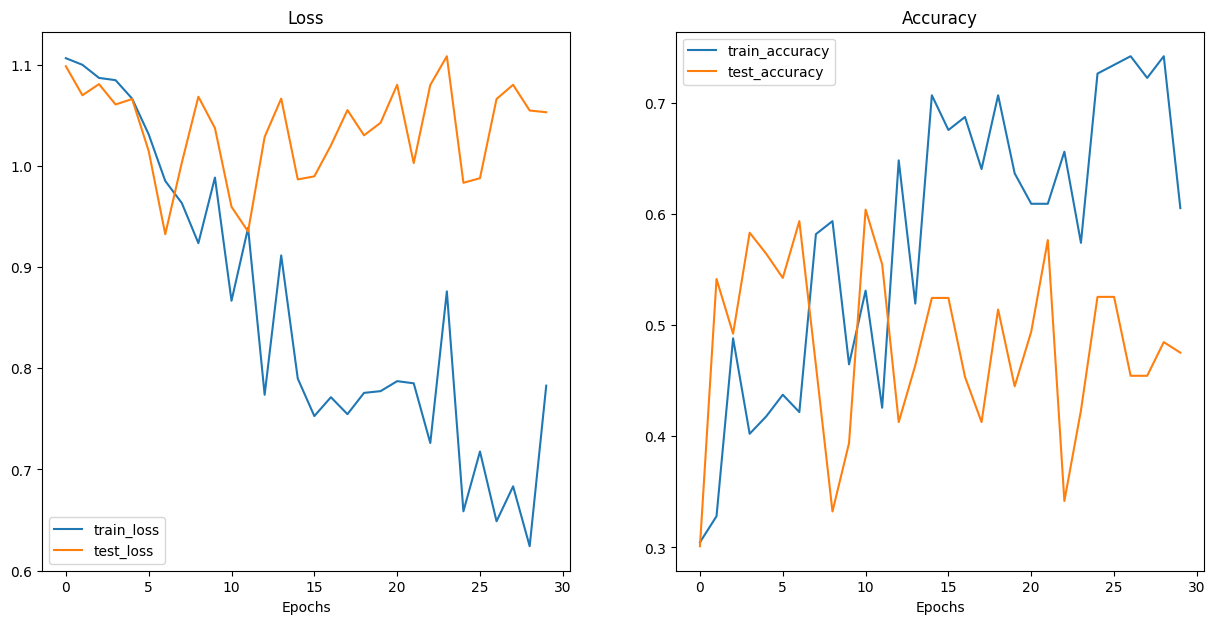

In [201]:
plot_loss_curves(results=model_0_results)

### 8 What should an ideal loss curve look like?
* Interpreting loss curves: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic
* pre-trained models: https://pytorch.org/vision/0.8/models.html

### 9 Model 1: TinyVGG with Data augmentation
* Now lets try another modeling experiment this time using the same model as before with some data augmentation

#### 9.1 Create transform with data augmentation

In [2]:
import torch
from torch import nn
from torchvision import transforms

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#### 9.2 Create train andtest `Dataset` and `DataLoaders` with Data Augmentation

In [8]:
from torchvision import datasets
from pathlib import Path
# Setup path to the data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [10]:
# Turn our Image folder to datasets
train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial,
                                          )
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_trivial)

In [11]:
# Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 1 #os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augment,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 9.3 Create another model_1 and train it
This time we will be using the same model class but with updated data augmentation.

In [18]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augment.classes)).to(device)

model_1


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Now lets create our loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [20]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 30

# setup loss and optimizer function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train the model 1
model_1_results = train_loop(model=model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn= loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out the time taken
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train Loss:  1.1037 | Train acc:  0.2500 | Test loss:  1.1004 | Test acc:  0.2604
Epoch: 1 | Train Loss:  1.0726 | Train acc:  0.4258 | Test loss:  1.1330 | Test acc:  0.2604
Epoch: 2 | Train Loss:  1.0812 | Train acc:  0.4258 | Test loss:  1.1682 | Test acc:  0.2604
Epoch: 3 | Train Loss:  1.1234 | Train acc:  0.3047 | Test loss:  1.1504 | Test acc:  0.2604
Epoch: 4 | Train Loss:  1.0847 | Train acc:  0.3438 | Test loss:  1.1487 | Test acc:  0.2917
Epoch: 5 | Train Loss:  1.0911 | Train acc:  0.3984 | Test loss:  1.1320 | Test acc:  0.3229
Epoch: 6 | Train Loss:  1.0387 | Train acc:  0.5898 | Test loss:  1.1231 | Test acc:  0.3229
Epoch: 7 | Train Loss:  1.0775 | Train acc:  0.5078 | Test loss:  1.1129 | Test acc:  0.3125
Epoch: 8 | Train Loss:  1.0694 | Train acc:  0.4062 | Test loss:  1.0859 | Test acc:  0.3636
Epoch: 9 | Train Loss:  1.0091 | Train acc:  0.4297 | Test loss:  0.9706 | Test acc:  0.3807
Epoch: 10 | Train Loss:  0.9304 | Train acc:  0.5703 | Test loss:  0.9

#### 9.4 Plot loss curvers of  model_1

In [25]:
# Importing libraries
from typing import Dict
import matplotlib.pyplot as plt

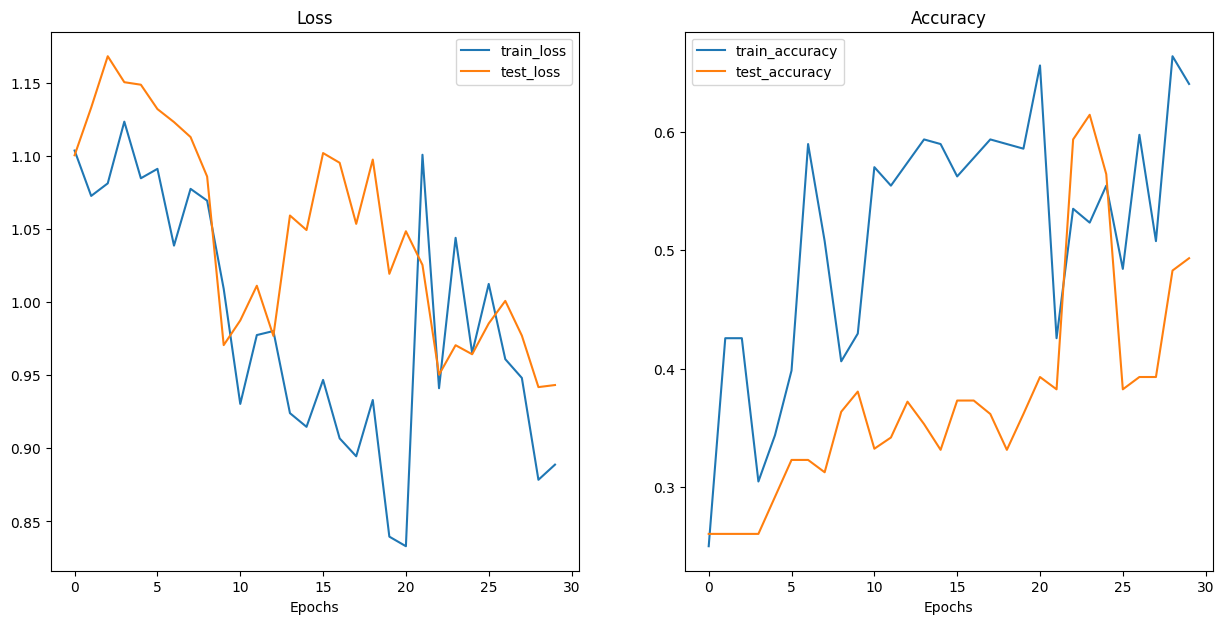

In [26]:
plot_loss_curves(model_1_results)

### 10 Comparing our model results
Afetr evaluating oour models experiments on their own, its important to compare then to each other

There's few different ways to do this:
1. Hard Coding ( What we are doing)
2. Pytorch + tensorboard
3. Weights and Biases
4. MLFLow

In [27]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df


NameError: name 'model_0_results' is not defined

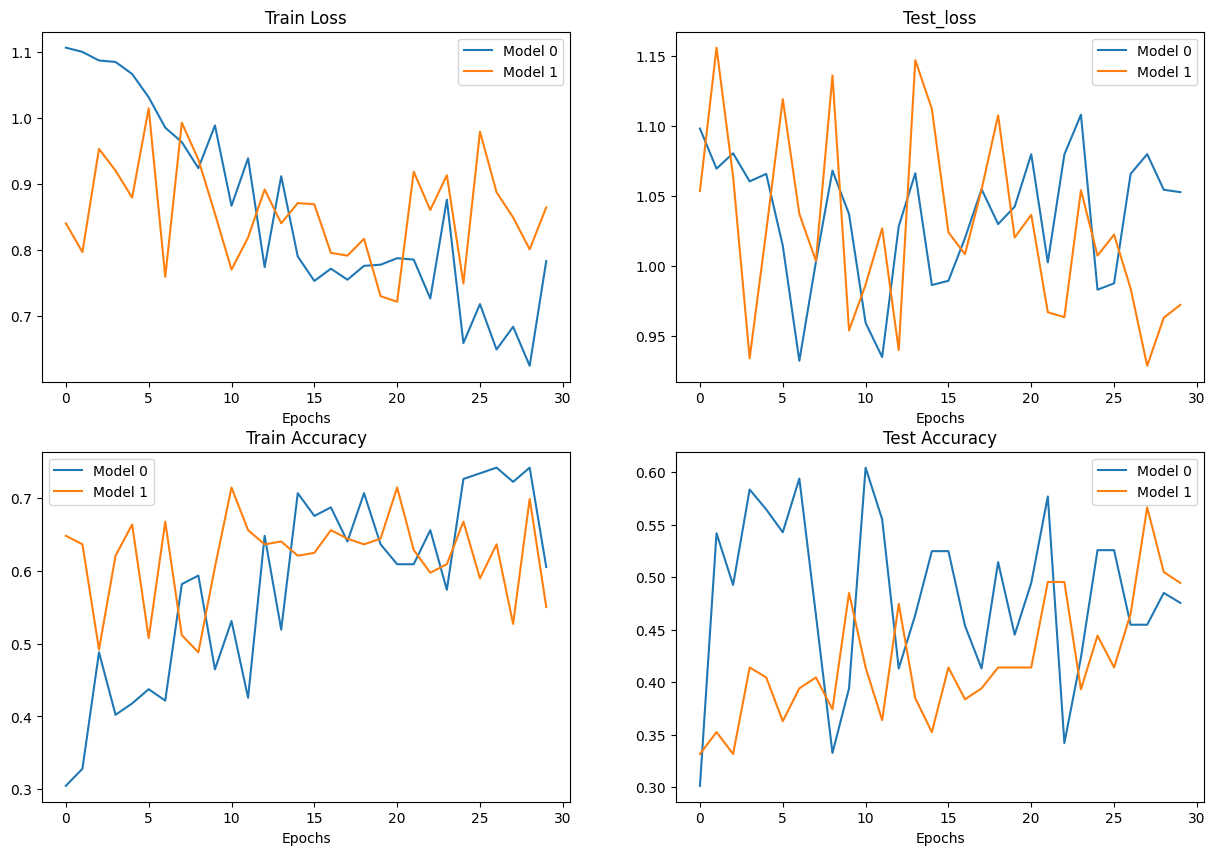

In [221]:
# setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot the trainloss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# plot the Test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test_loss")
plt.xlabel("Epochs")
plt.legend()

# plot the Train Accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# plot the Test Accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

### 11 Making a prediction on a custom image
Although we have trained our model on custom data ..... how do you make a prediction on a sample thats not in train and also in test dataset

In [28]:
# Download custom image
import requests

# setup custom image path
custom_image_path = data_path / "besthomemadepizzahero.jpg"

# Download the image if it doesn not exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloadign the image
        request = requests.get("https://therecipecritic.com/wp-content/uploads/2019/05/besthomemadepizzahero.jpg")
        print(f"Downloading..... {custom_image_path}")
        #print(request)
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping downloading")

data\besthomemadepizzahero.jpg already exists, skipping downloading


#### 11.1 Loading custom image with Pytorch
we ahve to make our custom image is in the same format as the data our model was trained on.
* In tensor form with datatype(torch.float32)
* of shape 64x64x3
* On the right Device
We can read an image into Pytorch using: https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [29]:
import torchvision

# read the custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

In [30]:
custom_image_uint8

tensor([[[248, 248, 248,  ..., 224, 191, 124],
         [248, 248, 248,  ..., 221, 232, 226],
         [248, 248, 248,  ..., 137, 158, 182],
         ...,
         [103, 104, 105,  ..., 111, 119, 135],
         [101, 103, 104,  ..., 116, 125, 141],
         [ 99, 101, 103,  ..., 122, 131, 147]],

        [[248, 248, 248,  ..., 234, 201, 134],
         [248, 248, 248,  ..., 231, 242, 236],
         [248, 248, 248,  ..., 147, 168, 192],
         ...,
         [123, 124, 125,  ..., 131, 139, 155],
         [121, 123, 124,  ..., 136, 145, 161],
         [119, 121, 123,  ..., 142, 151, 167]],

        [[248, 248, 248,  ..., 236, 203, 136],
         [248, 248, 248,  ..., 233, 244, 238],
         [248, 248, 248,  ..., 149, 170, 194],
         ...,
         [122, 123, 124,  ..., 130, 138, 154],
         [120, 122, 123,  ..., 135, 144, 160],
         [118, 120, 122,  ..., 141, 150, 166]]], dtype=torch.uint8)

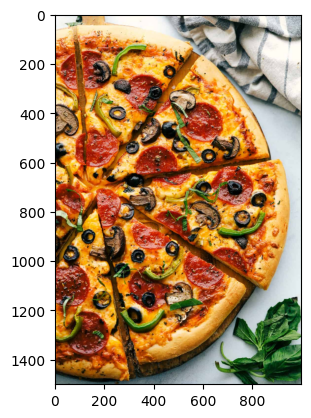

In [31]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [32]:
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom Image datatypes: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[248, 248, 248,  ..., 224, 191, 124],
         [248, 248, 248,  ..., 221, 232, 226],
         [248, 248, 248,  ..., 137, 158, 182],
         ...,
         [103, 104, 105,  ..., 111, 119, 135],
         [101, 103, 104,  ..., 116, 125, 141],
         [ 99, 101, 103,  ..., 122, 131, 147]],

        [[248, 248, 248,  ..., 234, 201, 134],
         [248, 248, 248,  ..., 231, 242, 236],
         [248, 248, 248,  ..., 147, 168, 192],
         ...,
         [123, 124, 125,  ..., 131, 139, 155],
         [121, 123, 124,  ..., 136, 145, 161],
         [119, 121, 123,  ..., 142, 151, 167]],

        [[248, 248, 248,  ..., 236, 203, 136],
         [248, 248, 248,  ..., 233, 244, 238],
         [248, 248, 248,  ..., 149, 170, 194],
         ...,
         [122, 123, 124,  ..., 130, 138, 154],
         [120, 122, 123,  ..., 135, 144, 160],
         [118, 120, 122,  ..., 141, 150, 166]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 1500, 1000])
Custom Image data

#### 11.2 Making predictions on a custom image with a trained pytorch model

In [33]:
# Error: Wrong image datatype
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [34]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(path=str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.9725, 0.9725, 0.9725,  ..., 0.8784, 0.7490, 0.4863],
         [0.9725, 0.9725, 0.9725,  ..., 0.8667, 0.9098, 0.8863],
         [0.9725, 0.9725, 0.9725,  ..., 0.5373, 0.6196, 0.7137],
         ...,
         [0.4039, 0.4078, 0.4118,  ..., 0.4353, 0.4667, 0.5294],
         [0.3961, 0.4039, 0.4078,  ..., 0.4549, 0.4902, 0.5529],
         [0.3882, 0.3961, 0.4039,  ..., 0.4784, 0.5137, 0.5765]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.9176, 0.7882, 0.5255],
         [0.9725, 0.9725, 0.9725,  ..., 0.9059, 0.9490, 0.9255],
         [0.9725, 0.9725, 0.9725,  ..., 0.5765, 0.6588, 0.7529],
         ...,
         [0.4824, 0.4863, 0.4902,  ..., 0.5137, 0.5451, 0.6078],
         [0.4745, 0.4824, 0.4863,  ..., 0.5333, 0.5686, 0.6314],
         [0.4667, 0.4745, 0.4824,  ..., 0.5569, 0.5922, 0.6549]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.9255, 0.7961, 0.5333],
         [0.9725, 0.9725, 0.9725,  ..., 0.9137, 0.9569, 0.9333],
         [0.9725, 0.9725, 0.9725,  ..., 0.5843, 0.6667, 0.

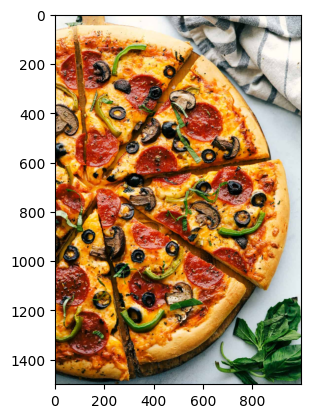

In [35]:
plt.imshow(custom_image.permute(1,2,0))

In [36]:
# Error cause image not in correct size
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x91884 and 1690x3)

In [37]:
# create a transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transfor the custom image
custom_image_transformed = custom_image_transform(custom_image)

# print out he shapes
print(f"Original image shape: {custom_image.shape}")
print(f"Transformed Image shape: {custom_image_transformed.shape}")

Original image shape: torch.Size([3, 1500, 1000])
Transformed Image shape: torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.012408054..1.0000001].


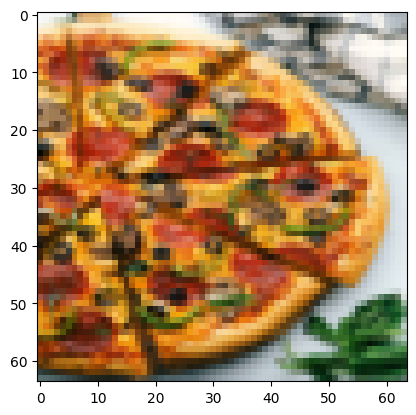

In [38]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [39]:
# this error we forgot to add batch dimension to it
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [40]:
# Adding an batch  dimension to the image
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [41]:
#
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [42]:
custom_image_pred

tensor([[ 0.4080, -1.0713, -0.1143]], device='cuda:0')

**Note** : To make the predictions on a custom image we had to :
* Load the image and turn it into a tensor
* Make sure the image was on the same datatype as the model
* Make sur ethe image was of the same shape as the data the mmodel was trained on 
* Make sure the image was on the same device as the model

In [43]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.5492, 0.1251, 0.3257]], device='cuda:0')

In [44]:
# Convert prediction probabilities -> predicted labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)

In [46]:
train_data_augment.classes[custom_image_pred_labels]

'pizza'